In [2]:
import numpy as np
# from geopy.distance import vincenty
from mpl_toolkits.basemap import Basemap
import h5py

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
%matplotlib inline

from scipy.interpolate import interp1d

Center (1187, 3)
InnerPerimeter (496, 3)
Inside (7749, 3)
OuterPerimeter (465, 3)
Outside (2457, 3)


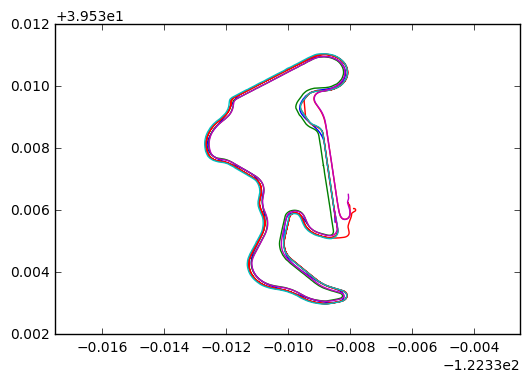

In [3]:
fileName = "Thunderhill_GPS.h5"
f = h5py.File(fileName,  "r")
Thunderhill_GPS = dict()
for item in f:
    Thunderhill_GPS[item] = f["/"+item][:]
    print(item, np.shape(Thunderhill_GPS[item]))
    plt.plot(Thunderhill_GPS[item][:,0],Thunderhill_GPS[item][:,1])

plt.axis('equal')
plt.show()

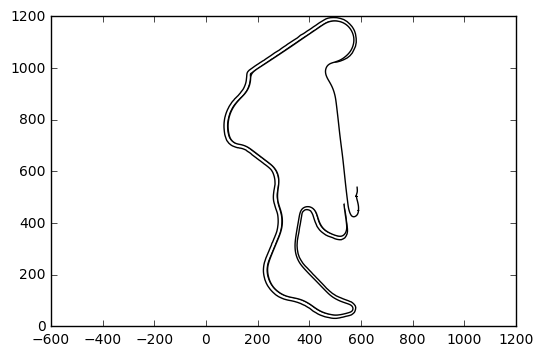

In [4]:
llcrnr = [ 39.532757, -122.343308] # Lower_left_corner_GPS
urcrnr = [ 39.541475, -122.337025] # Upper_right_corner_GPS

boundary_keys = ["OuterPerimeter","InnerPerimeter","Outside"]

fig = plt.figure()
ax = fig.add_subplot(111)
patch = []
vertices = []
path_codes = []
for k in boundary_keys:
    start = Thunderhill_GPS[k][0,:]
    m = Basemap(llcrnrlon=llcrnr[1],llcrnrlat=llcrnr[0],urcrnrlon=urcrnr[1],urcrnrlat=urcrnr[0],\
            projection='merc',lon_0=start[0],lat_0=start[1],resolution='h')
    
    verts = [m(Thunderhill_GPS[k][0,0],Thunderhill_GPS[k][0,1])]
    codes=[Path.MOVETO]
    
    for i in range(np.size(Thunderhill_GPS[k],0)):
        x1,y1=m(Thunderhill_GPS[k][i,0], Thunderhill_GPS[k][i,1])
        verts.append((x1,y1))
        codes.append(Path.LINETO)

    path = Path(verts, codes)
    patch.append(patches.PathPatch(path, facecolor='white'))
    vertices.append(verts)
    path_codes.append(codes)

# Axis limits
ll_x,ll_y = m(llcrnr[1],llcrnr[0])
ur_x,ur_y = m(urcrnr[1],urcrnr[0])

ax.set_xlim(ll_x,ur_x)
ax.set_ylim(ll_y,ur_y)

p = PatchCollection(patch,linewidths = (1,),edgecolors = ((0,0,0,1),), facecolors = 'white')

ax.add_collection(p)

# # # S/F line
# ax.set_xlim(480,520)
# ax.set_ylim(650,700)

plt.axis('equal')
plt.show()               

OuterPerimeter lap Length of Thunderhill west is  3505.9290514
InnerPerimeter lap Length of Thunderhill west is  3414.94282344
Outside lap Length of Thunderhill west is  3541.80046497


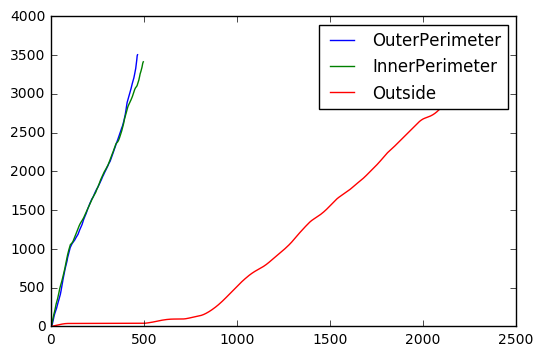

In [5]:
## Compute distance between each data point for both inner & outer perimeter
dist = []
perimeter_matrix = []
for v in vertices:
    ds = [0]
    p_mat = []
    for p in range(0,len(v)-1):
        dist_pts = np.sqrt((v[p][0]-v[p+1][0])**2 +  (v[p][1]-v[p+1][1])**2)
        ds.append(ds[-1]+dist_pts)
        p_mat.append([ds[-1],v[p][0],v[p][1]])
#     dist_pts = np.sqrt((v[-1][0]-v[0][0])**2 +  (v[-1][1]-v[0][1])**2)
#     ds.append(ds[-1]+dist_pts)
#     p_mat.append([ds[-1],v[0][0],v[0][0]])
    
    perimeter_matrix.append(np.array(p_mat))
    dist.append(ds)

for i in range(len(boundary_keys)):
    print(boundary_keys[i] + " lap Length of Thunderhill west is " ,  dist[i][-1])
    plt.plot(dist[i])
plt.legend(boundary_keys)
plt.show()

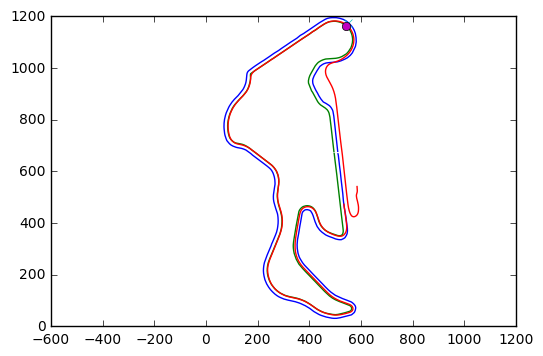

In [6]:
## In this code block, we interpolate the co-ordinates at regular distances. Since lap length is about 3500m, we create
## datapoints every 1m, so about 3500 pts.
nPts = 3500
distance_outer = np.linspace(0,dist[0][-1],nPts)
distance_inner = np.linspace(0,dist[1][-1],nPts)
distance_line = np.linspace(0,dist[2][-1],nPts)

f_outer = interp1d(perimeter_matrix[0][:,0], perimeter_matrix[0][:,1:],axis=0)#, kind='cubic')
f_inner = interp1d(perimeter_matrix[1][:,0], perimeter_matrix[1][:,1:],axis=0)#, kind='cubic')
f_line = interp1d(perimeter_matrix[2][:,0], perimeter_matrix[2][:,1:],axis=0)#, kind='cubic')

inner_mat = f_inner(distance_inner)
outer_mat = f_outer(distance_outer)
line_mat = f_line(distance_line)

matrix = [outer_mat, inner_mat, line_mat]

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(len(matrix)):
    plt.plot(matrix[i][:,0],matrix[i][:,1])

ax.set_xlim(ll_x,ur_x)
ax.set_ylim(ll_y,ur_y)

ind = 650
plt.plot(matrix[0][ind,0],matrix[0][ind,1],'x')
plt.plot(matrix[1][ind,0],matrix[1][ind,1],'o')

plt.axis('equal')
plt.show()

## In the plot below, the circle represents a point on the inner perimeter
## The cross points to an point on the outer perimeter.
## Note how these two points are perpendicular to the tangent to the track at that point.

In [7]:
## Now that all points are (almost) equi-distant, we can compute the centerline as the average co-ordinate
## of the corresponding inner and outer co-ordinates.
centerline = np.vstack(((matrix[0][:,0]+matrix[1][:,0])/2.0,(matrix[0][:,1]+matrix[1][:,1])/2.0)).T
print(np.shape(centerline))

(3500, 2)


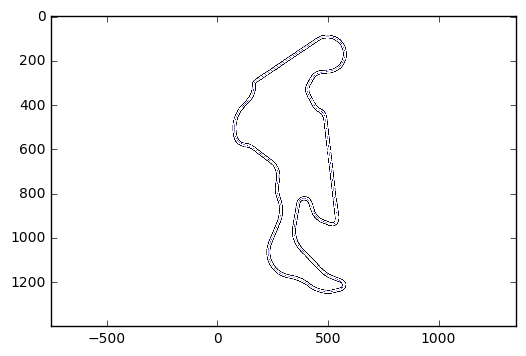

In [69]:
import cv2
img = np.zeros((1400,600, 3), np.uint8)
img[:,:,0] = 255*np.ones((1400,600))
img[:,:,1] = 255*np.ones((1400,600))
img[:,:,2] = 255*np.ones((1400,600))

avg_yc = np.mean(centerline[:,1])

for i in range(1,nPts):
#     cv2.line(img,(int(matrix[0][i-1,0]),int(matrix[0][i-1,1])),(511,511),(255,0,0),5)
    cv2.line(img,(int(matrix[0][i-1,0]),int(2*avg_yc-matrix[0][i-1,1])+100),\
             (int(matrix[0][i,0]),int(2*avg_yc-matrix[0][i,1])+100), color=(1,1,1,), thickness=2)
    cv2.line(img,(int(matrix[1][i-1,0]),int(2*avg_yc-matrix[1][i-1,1])+100),\
             (int(matrix[1][i,0]),int(2*avg_yc-matrix[1][i,1])+100), color=(1,1,1,), thickness=2)
    cv2.line(img,(int(centerline[i-1,0]),int(2*avg_yc-centerline[i-1,1])+100),\
             (int(centerline[i,0]),int(2*avg_yc-centerline[i,1])+100), color=(1,1,255,), thickness=1)
#     cv2.circle(img,(int(matrix[2][i-1,0]),int(2*avg_yc-matrix[2][i-1,1])), 1, (0,0,255))

plt.axis('equal')

# # S/F line
# ax.set_xlim(480,520)
# ax.set_ylim(650,700)

 # Crop from x, y, w, h -> 100, 200, 300, 400
# NOTE: its img[y: y + h, x: x + w] and *not* img[x: x + w, y: y + h]
# cv2.imshow('cropped',crop_img)


plt.imshow(img)

In [70]:
import imageio
imageio.plugins.ffmpeg.download()
import numpy as np
import moviepy.editor as mpy
import cv2
W = 1
fps = 24
maxp = np.size(matrix[2],0)
## Reflect matrix, so that track gets displayed correctly on the image.


def make_frame(t):
    pi = int(t * fps) % maxp
    p = (matrix[2][pi,0],matrix[2][pi,1])
    if pi > 0:
        p_prev = (int(matrix[2][pi-fps,0]),int(2*avg_yc-matrix[2][pi-fps,1]+100))
        for i in range(fps):
            p1 = (int(matrix[2][pi-fps+i,0]),int(2*avg_yc-matrix[2][pi-fps+i,1]+100))
            cv2.line(img,p_prev,p1, color=(255,1,1,), thickness=1)
            p_prev = p1
            
    current_pos = (int(p[0]), int(2*avg_yc-p[1])+100)
    
    cp_img = np.copy(img)
    cv2.circle(cp_img,(current_pos[0], current_pos[1]), pi % 10, (255,0,0),3)
#     crop_img = cp_img[current_pos[0]-10:current_pos[0]+10,current_pos[1]-10:current_pos[1]+10,:];
    return cp_img # returns a 8-bit RGB array

clip = mpy.VideoClip(make_frame, duration=(int(maxp/fps)+1)) # 2 seconds
clip.write_videofile("path.mp4",fps=fps, codec='mpeg4')

[MoviePy] >>>> Building video path.mp4
[MoviePy] Writing video path.mp4


100%|█████████▉| 3504/3505 [00:21<00:00, 164.97it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: path.mp4 

